In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the project folder
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DeepfakeDetectionModel'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Dataset', 'Code', 'Models', 'resnet34_train.ipynb']


In [3]:
DATASET_FOLDER = os.path.join(GOOGLE_DRIVE_PATH, 'Dataset', 'Dataset_Cropped')
CODE_FOLDER = os.path.join(GOOGLE_DRIVE_PATH, 'Code')
print(os.listdir(DATASET_FOLDER))
print(os.listdir(CODE_FOLDER))

['.DS_Store', 'train', 'test']
['resnet34.py', '__pycache__', 'resnet152.py', 'calculate_mean_std.py', 'resnet50.py']


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append(CODE_FOLDER)

In [6]:
from resnet50 import ResNet50
from calculate_mean_std import calculate_mean_std

In [7]:
train_dataset_path = os.path.join(DATASET_FOLDER, 'train')

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [10]:
stats_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])

stats_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=stats_transform)

stats_loader = DataLoader(stats_dataset, batch_size=4, shuffle=True, num_workers=2)

calc_mean, calc_std = calculate_mean_std(stats_loader)

print(f'Mean: {calc_mean}')
print(f'Std: {calc_std}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Mean: tensor([0.5498, 0.4155, 0.3822])
Std: tensor([0.2164, 0.1714, 0.1615])


In [11]:
transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=calc_mean, std=calc_std),
])

dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dataset_path, validation_split=0.2, subset="training", seed=123)

Found 2948 files belonging to 3 classes.
Using 2359 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(train_dataset_path, validation_split=0.2, subset="validation", seed=123)

Found 2948 files belonging to 3 classes.
Using 589 files for validation.


In [14]:
model = ResNet50()

In [15]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [16]:
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])

In [17]:
num_epochs = 100
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Epoch 1/100
74/74 [==============================] - 91s 613ms/step - loss: 14.0216 - accuracy: 0.3158 - val_loss: 1.3895 - val_accuracy: 0.3158
Epoch 2/100
74/74 [==============================] - 39s 511ms/step - loss: 1.6743 - accuracy: 0.3209 - val_loss: 1.1115 - val_accuracy: 0.3463
Epoch 3/100
74/74 [==============================] - 40s 533ms/step - loss: 1.2398 - accuracy: 0.3408 - val_loss: 1.1926 - val_accuracy: 0.3497
Epoch 4/100
74/74 [==============================] - 41s 533ms/step - loss: 1.1643 - accuracy: 0.3396 - val_loss: 1.0979 - val_accuracy: 0.3413
Epoch 5/100
74/74 [==============================] - 41s 533ms/step - loss: 1.2055 - accuracy: 0.3349 - val_loss: 1.1199 - val_accuracy: 0.3497
Epoch 6/100
74/74 [==============================] - 42s 554ms/step - loss: 1.1286 - accuracy: 0.3654 - val_loss: 1.1056 - val_accuracy: 0.3531
Epoch 7/100
74/74 [==============================] - 41s 539ms/step - loss: 1.1050 - accuracy: 0.3701 - val_loss: 1.1080 - val_accuracy

In [18]:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
model.save(os.path.join(save_path, 'resnet50'))

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

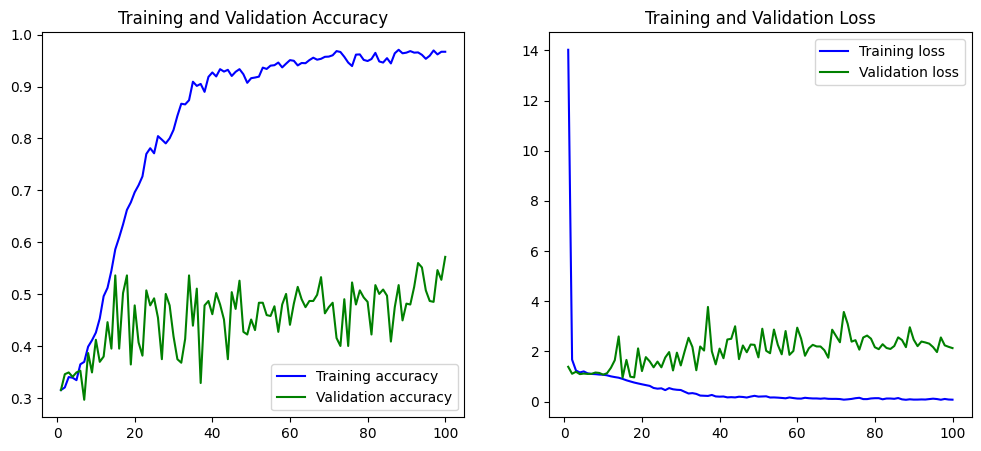

In [20]:
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()